# 4. Árboles de Decisión: Predicción de Supervivencia (Titanic)

### 4.1. Objetivo y Dataset
El objetivo es construir un modelo de clasificación basado en **Árboles de Decisión** para predecir si un pasajero sobrevivió o no al naufragio del Titanic, basándonos en sus características socioeconómicas.

**Dataset:** Titanic (Data Science Dojo - GitHub Mirror).
* **Variable Objetivo ($y$):** `Survived` (0 = No sobrevivió, 1 = Sobrevivió).
* **Variables Predictoras ($X$):** Clase (Pclass), Sexo, Edad, Tarifa (Fare), Puerto de Embarque (Embarked), etc.

**Tarea:** Preprocesar variables, convertir datos categóricos y ajustar los hiperparámetros del árbol para evitar el sobreajuste (*overfitting*).

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Carga de datos (Link estable)
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(url)

# 2. Selección de variables relevantes
# Descartamos 'Name', 'Ticket' y 'Cabin' porque requieren procesamiento de texto avanzado (NLP)
cols = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
df = df[cols]

# 3. Tratamiento de Nulos
# Rellenamos la edad faltante con la mediana (es más robusto que el promedio)
df['Age'] = df['Age'].fillna(df['Age'].median())
# Eliminamos las 2 filas que no tienen puerto de embarque
df.dropna(subset=['Embarked'], inplace=True)

print(f"✅ Datos limpios: {df.shape} filas/cols")
df.head()

✅ Datos limpios: (889, 8) filas/cols


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


### 4.2. Preprocesamiento de Variables Categóricas

Los modelos de Scikit-Learn requieren entradas numéricas. Las variables **`Sex`** (texto) y **`Embarked`** (texto) deben ser transformadas.

Utilizamos **One-Hot Encoding** (`get_dummies`):
* Convierte cada categoría en una columna nueva de ceros y unos.
* `drop_first=True`: Elimina una de las columnas para evitar redundancia (multicolinealidad).

In [2]:
# 1. Convertir categóricas a numéricas
df = pd.get_dummies(df, columns=['Sex', 'Embarked'], drop_first=True)

# 2. Separar X (Predictoras) e y (Objetivo)
X = df.drop('Survived', axis=1)
y = df['Survived']

# 3. División Train/Test (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Variables listas para el modelo:")
print(X.columns.tolist())

Variables listas para el modelo:
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_male', 'Embarked_Q', 'Embarked_S']


### 4.3. Ajuste de Hiperparámetros

Un Árbol de Decisión tiende a memorizar los datos de entrenamiento si no se le ponen límites (Overfitting). Para optimizar el modelo, ajustamos los siguientes hiperparámetros usando `GridSearchCV`:

1.  **`max_depth` (Profundidad Máxima):**
    * *¿Qué es?* El número máximo de niveles (preguntas) que puede tener el árbol.
    * *¿Para qué sirve?* Controla la complejidad. Un árbol muy profundo aprende el "ruido" de los datos; uno muy corto no aprende lo suficiente (underfitting).
2.  **`min_samples_split`:**
    * *¿Qué es?* El número mínimo de muestras necesarias para dividir un nodo interno.
    * *¿Para qué sirve?* Evita crear nodos muy específicos basados en muy pocos datos.
3.  **`min_samples_leaf`:**
    * *¿Qué es?* El número mínimo de muestras que debe tener una hoja final.
    * *¿Para qué sirve?* Garantiza que cada decisión final tenga un respaldo estadístico suficiente.

In [3]:
# Definir la rejilla de parámetros a probar
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Configurar búsqueda automática (Cross-Validation de 5 pliegues)
grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Entrenar probando todas las combinaciones
print("⚙️ Entrenando modelo (esto prueba cientos de combinaciones)...")
grid.fit(X_train, y_train)

best_model = grid.best_estimator_

print("-" * 30)
print(f"✅ Mejores Parámetros: {grid.best_params_}")
print(f"✅ Mejor Exactitud en Validación: {grid.best_score_:.2%}")


⚙️ Entrenando modelo (esto prueba cientos de combinaciones)...
------------------------------
✅ Mejores Parámetros: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
✅ Mejor Exactitud en Validación: 81.86%


### 4.4. Evaluación y Visualización
Evaluamos el mejor modelo encontrado con los datos de prueba (`X_test`) que nunca ha visto.

🏆 EXACTITUD EN TEST: 82.02%

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       109
           1       0.76      0.78      0.77        69

    accuracy                           0.82       178
   macro avg       0.81      0.81      0.81       178
weighted avg       0.82      0.82      0.82       178



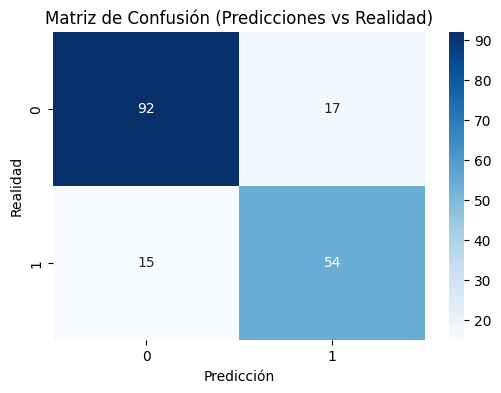

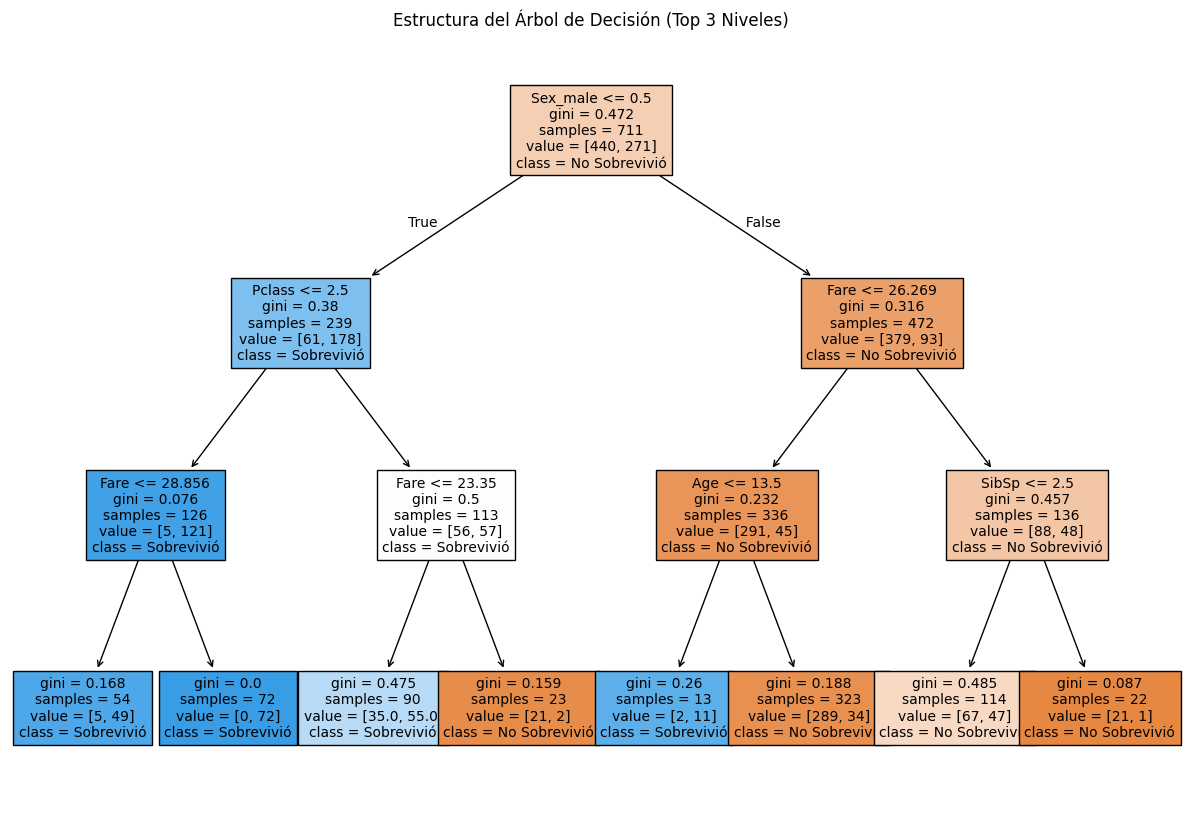

In [4]:
# Predicción final
y_pred = best_model.predict(X_test)

# Métricas
acc = accuracy_score(y_test, y_pred)
print(f"🏆 EXACTITUD EN TEST: {acc:.2%}")
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Matriz de Confusión Visual
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión (Predicciones vs Realidad)')
plt.ylabel('Realidad')
plt.xlabel('Predicción')
plt.show()

# Visualización del Árbol (Solo los primeros 3 niveles para que sea legible)
plt.figure(figsize=(15, 10))
plot_tree(best_model, feature_names=X.columns, class_names=['No Sobrevivió', 'Sobrevivió'], filled=True, max_depth=3, fontsize=10)
plt.title("Estructura del Árbol de Decisión (Top 3 Niveles)")
plt.show()